In [16]:
import pandas as pd
import numpy as np
import nltk
# nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sparse_dot_topn import awesome_cossim_topn


In [17]:
df = pd.read_csv('https://s3-eu-west-1.amazonaws.com/adthena-ds-test/trainSet.csv',names = ['query', 'category'])
df_test = pd.read_csv('https://s3-eu-west-1.amazonaws.com/adthena-ds-test/candidateTestSet.txt',names = ['query'])
df.head()

,query,category
0,yew hedge,1221
1,fire detection shop,19
2,cheap couch roll,398
3,extra watermelon gum,1108
4,used generators for sale uk,213


In [14]:
df.shape

(606823, 2)

In [9]:
df.duplicated().any()

False

In [11]:
df.isnull().any()

search_term    False
category       False
dtype: bool

In [18]:
len(df.category.unique())

1419

<AxesSubplot:>

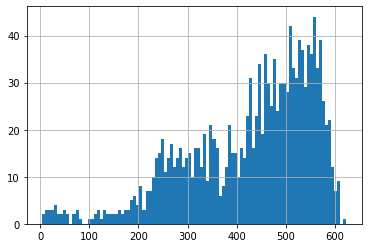

In [23]:
df.category.value_counts().hist(bins=100)

In [31]:
df.groupby('category').size().mean()

427.64129668780834

# 2-4 keywords

In [ ]:
df['l']=df['query'].apply(lambda x: len(x.split(' ')))
df.l.hist(bins=df['l'].max()*2)

# Category labels are noisy, perhaps generated by another model

In [80]:
df[df['query'].str.contains('picnic blanket argos')]

,query,category,l
506744,picnic blanket argos,203,3


In [77]:
df[df['query'].str.contains('argos picnic blanket')]

,query,category,l
110420,argos picnic blanket,239,3


# Contains  non english queries

In [183]:
df.sort_values('query').tail(10)

,query,category,l,all_english,translated,query_lem
167295,語学 留学,1112,2,True,NaN,語学 留学
477654,論文 代 寫,724,3,True,NaN,論文 代 寫
175426,论文 代 写,724,3,True,NaN,论文 代 写
478921,论文 代 写 价格,724,4,True,NaN,论文 代 写 价格
303869,论文 修改,724,2,True,NaN,论文 修改
503999,论文 润色,724,2,True,NaN,论文 润色
221166,갤럭시 s7,1007,2,True,NaN,갤럭시 s7
137434,아이폰 6s,1007,2,True,NaN,아이폰 6
476067,알람,1007,1,True,NaN,알람
145677,유럽 여행,819,2,True,NaN,유럽 여행


In [18]:
wl = WordNetLemmatizer()
def lem(string):
    lem_w = [wl.lemmatize(w) for w in string.split(' ')]
    return ' '.join(lem_w)
df['query_lem']=df['query'].apply(lem)

# Model: most frequent category within top20 most similar labeled searches (very fast)

In [93]:
df_train, df_test=train_test_split(df,test_size=0.1, stratify=df.category.values, random_state=1)

vv=TfidfVectorizer()
features_train=vv.fit_transform(df_train.query_lem.values)
features_test=vv.transform(df_test.query_lem.values)

# Find top20 most similar matches
matches = awesome_cossim_topn(features_test, features_train.transpose(), 20, 0.01)
ind=np.argwhere(matches)
i1=ind[:,0]
i2=ind[:,1]

df_test.reset_index(inplace=True)
df_test=df_test.rename(columns={'index':'index1'})

queries=np.take(df_test['query'].values, i1)
index1=np.take(df_test['index1'].values, i1)
sim=matches.data
categories=np.take(df_train.category.values, i2)
queries_train=np.take(df_train['query'].values, i2)
df2=pd.DataFrame(data={'queries_test':queries,'queries_train':queries_train, 'cat':categories , 'index1':index1, 'sim':sim})

df2.head(40)

,queries_test,queries_train,cat,index1,sim
0,top isas martin lewis,top isas,1101,187934,0.731510
1,top isas martin lewis,martins money tips isas,524,187934,0.618227
2,top isas martin lewis,martin lewis book,524,187934,0.616584
3,top isas martin lewis,martin lewis loans,55,187934,0.572426
4,top isas martin lewis,martin lewis debt,853,187934,0.570107
5,top isas martin lewis,martin lewis pensions,45,187934,0.565111
6,top isas martin lewis,martin lewis com,524,187934,0.563574
7,top isas martin lewis,martin lewis energy,694,187934,0.557551
8,top isas martin lewis,ppi martin lewis,567,187934,0.557413
9,top isas martin lewis,martin lewis car insurance,1386,187934,0.555967


# Hold out sample accuracy 0.56

In [92]:
pred=df2[['queries_test','index1','cat']].groupby(['queries_test','index1']).agg(lambda x:scipy.stats.mode(x)[0])
pred=pred.reset_index()
pred1=pred.merge(df_test[['index1', 'category']].rename(columns={'category':'cat_true'}), on='index1', how='left')
pred1['match']=(pred1.cat==pred1.cat_true).astype(int)
print('Hold out sample accuracy', np.round(pred1['match'].mean(),2))

Hold out sample accuracy 0.56


In [94]:
# Make Predictions
df_test = pd.read_csv('/home/mindis/Downloads/candidateTestSet.txt',names = ['query'])
df_test['query_lem']=df_test['query'].apply(lem)
features_test=vv.transform(df_test.query_lem.values)

matches = awesome_cossim_topn(features_test, features_train.transpose(), 20, 0.01)
ind=np.argwhere(matches)
i1=ind[:,0]
i2=ind[:,1]

df_test.reset_index(inplace=True)
df_test=df_test.rename(columns={'index':'index1'})

queries=np.take(df_test['query'].values, i1)
index1=np.take(df_test['index1'].values, i1)
sim=matches.data
categories=np.take(df_train.category.values, i2)
queries_train=np.take(df_train['query'].values, i2)
df2=pd.DataFrame(data={'queries_test':queries,'queries_train':queries_train, 'cat':categories , 'index1':index1, 'sim':sim})

df2.head(20)

,queries_test,queries_train,cat,index1,sim
0,twister picnic blanket,picnic blanket,203,0,0.722819
1,twister picnic blanket,m&s picnic blanket,1035,0,0.722819
2,twister picnic blanket,picnic blanket uk,203,0,0.688065
3,twister picnic blanket,argos picnic blanket,239,0,0.647670
4,twister picnic blanket,picnic blanket argos,203,0,0.647670
5,twister picnic blanket,large picnic blanket,950,0,0.629344
6,twister picnic blanket,asda picnic blanket,203,0,0.627115
7,twister picnic blanket,picnic blanket asda,203,0,0.627115
8,twister picnic blanket,twister game,983,0,0.603508
9,twister picnic blanket,picnic blanket waterproof,203,0,0.598448


# Lets try logistic regression with Vowpall Wabbit: fast, lots of options to finetune, balance accuracy vs memory requirements


In [343]:
df = pd.read_csv('https://s3-eu-west-1.amazonaws.com/adthena-ds-test/trainSet.csv',names = ['query', 'category'])
df=df.sample(frac=1)
df['query_lem']=df['query'].apply(lem)
df.head()

,query,category,query_lem
243080,what are the best trainers,1372,what are the best trainer
50150,factory for sale,631,factory for sale
105628,discus fish for sale,1217,discus fish for sale
581494,uk private jet,765,uk private jet
258166,fertan,903,fertan


In [19]:
# vw needs categories to start from 1
df.category=df.category+1
df['vw_train']=df.category.astype(str)+ ' | ' + df['query_lem'].values
df['vw_test']='| ' + df['query_lem'].values
df_train, df_test=train_test_split(df, test_size=0.2, stratify=df.category.values)
df_train[['vw_train']].to_csv('/home/mindis/vw_query.train', header=False, index=False)
df_test[['vw_test']].to_csv('/home/mindis/vw_query.test', header=False, index=False)

In [345]:
# !vw --log_multi 1419 --loss_function=hinge --ngram=2 --skips=2 -d /home/mindis/vw_query.train -f /home/mindis/model2.vw --passes 5 --random_seed 17 --cache_file ./tmp1 -b 30  --l2=1e-6
# !vw --oaa 1419 --loss_function=hinge --ngram=2 -d /home/mindis/vw_query.train -f /home/mindis/model2.vw --passes 5 --random_seed 17 --cache_file ./tmp1 -b 26  --l2=1e-6
# !vw --oaa 1419 -d /home/mindis/vw_query.train -f /home/mindis/model2.vw --passes 5 --random_seed 17 --cache_file ./tmp1 -b 26  
# 0.49

!vw --oaa 1419 -d /home/mindis/vw_query.train -f /home/mindis/model2.vw --passes 5 --random_seed 17 --cache_file ./tmp1 -b 27


# !vw --oaa 1419 /home/mindis/vw_query.train -f /home/mindis/model2.vw --passes 3 -b 26 --random_seed 17 -c
# !vw --oaa 1419 -d /home/mindis/vw_query.train -f /home/mindis/model2.vw --passes 3 --random_seed 17 -c ./tmp1
# !vw --oaa 1419 -d /home/mindis/vw_query.train -f /home/mindis/model2.vw --passes 5 --random_seed 17 --cache_file ./tmp1 -b 30  --l2=1e-6

final_regressor = /home/mindis/model2.vw
Num weight bits = 27
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
using cache_file = ./tmp1
ignoring text input in favor of cache input
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      704        1        3
1.000000 1.000000            2            2.0     1035      704        4
1.000000 1.000000            4            4.0     1340      704        4
1.000000 1.000000            8            8.0      888     1035        4
1.000000 1.000000           16           16.0      512     1035        4
1.000000 1.000000           32           32.0       94      725        4
1.000000 1.000000           64           64.0     1136     1271        3
1.000000 1.000000          128          128.0     1218     1370        5
0.980469 0.960938          256          256.0     

# score hold out

In [346]:
!vw -t -d /home/mindis/vw_query.test -i /home/mindis/model2.vw -p /home/mindis/predict1.vw

only testing
predictions = /home/mindis/predict1.vw
Num weight bits = 27
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = /home/mindis/vw_query.test
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
    n.a.     n.a.            1            1.0  unknown      218        4
    n.a.     n.a.            2            2.0  unknown      681        5
    n.a.     n.a.            4            4.0  unknown      680        4
    n.a.     n.a.            8            8.0  unknown     1002        3
    n.a.     n.a.           16           16.0  unknown      324        3
    n.a.     n.a.           32           32.0  unknown      796        4
    n.a.     n.a.           64           64.0  unknown     1415        2
    n.a.     n.a.          128          128.0  unknown      374        3
    n.a.     n.a.          256          256.0  unknown     1080        5

# VW hold out accuracy 0.77 (sorry no cross validation)

In [347]:
pred=pd.read_csv('/home/mindis/predict1.vw', names=['pred'])
df_test['pred']=pred['pred'].values
df_test['hit']=(df_test['pred']==df_test['category']).astype(int)
df_test.hit.mean()

<ipython-input-347-68d0e34ed0c6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred']=pred['pred'].values
<ipython-input-347-68d0e34ed0c6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['hit']=(df_test['pred']==df_test['category']).astype(int)


0.7715486342850081

In [348]:
df_test

,query,category,query_lem,vw_train,vw_test,pred,hit
278442,government website petitions,1094,government website petition,1094 | government website petition,| government website petition,218,0
532003,glue wood to metal,681,glue wood to metal,681 | glue wood to metal,| glue wood to metal,681,1
78444,subbuteo,984,subbuteo,984 | subbuteo,| subbuteo,800,0
384160,rick stein books,680,rick stein book,680 | rick stein book,| rick stein book,680,1
88672,kids ear defenders,285,kid ear defender,285 | kid ear defender,| kid ear defender,830,0
...,...,...,...,...,...,...,...
65912,mitel uc360,439,mitel uc360,439 | mitel uc360,| mitel uc360,439,1
1308,bmw offers,882,bmw offer,882 | bmw offer,| bmw offer,882,1
204343,moroccan oil boots,672,moroccan oil boot,672 | moroccan oil boot,| moroccan oil boot,672,1
344588,vinyl albums for sale,1287,vinyl album for sale,1287 | vinyl album for sale,| vinyl album for sale,1287,1


In [22]:
df['vw_train']=df.category.astype(str)+ ' | ' + df['query_lem'].values
train_list=list(df['vw_train'].values)

In [28]:
# Train log-transform model
from vowpalwabbit import pyvw
import numpy as np
training_samples = []
vw = pyvw.vw("--oaa 1419 --random_seed 17 --cache_file ./tmp1 -b 27 -f /home/mindis/model2.vw ")
for iteration in range(3):
    for i in range(len(train_list)):
        vw.learn(train_list[i])
vw.finish()

In [24]:
# Generate predictions from the log-transform model
vw = pyvw.vw("-i /home/mindis/model2.vw  -t")
pred = [vw.predict(sample) for sample in train_list]
# Measure bias in the log-domain
log_bias = np.mean(log_predictions - logz)
bias = np.mean(np.exp(log_predictions) - z)

In [27]:
df['pred']=pred
df['hit']=(df['pred']==df['category']).astype(int)
df.hit.mean()

0.7320998050502371

# score test set

# train model on all data

In [352]:
df[['vw_train']].to_csv('/home/mindis/vw_query.train', header=False, index=False)
# !vw --oaa 1419 -d /home/mindis/vw_query.train -f /home/mindis/model2.vw --passes 5 --random_seed 17 --cache_file ./tmp1 -b 27


final_regressor = /home/mindis/model2.vw
Num weight bits = 27
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
using cache_file = ./tmp1
ignoring text input in favor of cache input
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      704        1        3
1.000000 1.000000            2            2.0     1035      704        4
1.000000 1.000000            4            4.0     1340      704        4
1.000000 1.000000            8            8.0      888     1035        4
1.000000 1.000000           16           16.0      512     1035        4
1.000000 1.000000           32           32.0       94      725        4
1.000000 1.000000           64           64.0     1136     1271        3
1.000000 1.000000          128          128.0     1218     1370        5
0.980469 0.960938          256          256.0     

In [353]:
df_test = pd.read_csv('https://s3-eu-west-1.amazonaws.com/adthena-ds-test/candidateTestSet.txt',names = ['query'])
df_test['query_lem']=df_test['query'].apply(lem)
df_test['vw_test']='| ' + df_test['query'].values
df_test[['vw_test']].to_csv('/home/mindis/vw_query.submission', header=False, index=False)

In [354]:
!vw -t -d /home/mindis/vw_query.submission -i /home/mindis/model2.vw -p /home/mindis/predict1.subm

only testing
predictions = /home/mindis/predict1.subm
Num weight bits = 27
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = /home/mindis/vw_query.submission
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
    n.a.     n.a.            1            1.0  unknown      204        4
    n.a.     n.a.            2            2.0  unknown     1395        5
    n.a.     n.a.            4            4.0  unknown     1272        3
    n.a.     n.a.            8            8.0  unknown      419        3
    n.a.     n.a.           16           16.0  unknown     1367        4
    n.a.     n.a.           32           32.0  unknown      197        3
    n.a.     n.a.           64           64.0  unknown      860        3
    n.a.     n.a.          128          128.0  unknown      754        5
    n.a.     n.a.          256          256.0  unknown      532 

In [355]:
pred=pd.read_csv('/home/mindis/predict1.subm', names=['pred'])
pred.pred=pred.pred-1
pred.to_csv('/home/mindis/adthena_mz/data/pred_lr.csv', index=None, header=False)
